In [3]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

from numpy.fft import fft, fftshift, fftfreq
from matplotlib import pyplot as plt
from pathlib import Path
import ffmpeg, librosa

def get_audio_data(mp4_file):
    probe = ffmpeg.probe(mp4_file)
    audio_stream = next((stream for stream in probe['streams'] 
                        if stream['codec_type'] == 'audio'), None)
    
    if audio_stream is None:
        raise ValueError(f"No audio stream found in {mp4_file}")
    
    sr = int(audio_stream['sample_rate'])
    channels = int(audio_stream['channels'])
    
    out, _ = (
        ffmpeg
        .input(mp4_file)
        .output('-', format='s16le', acodec='pcm_s16le')
        .run(capture_stdout=True, capture_stderr=True)
    )
    
    audio_array = np.frombuffer(out, dtype=np.int16)
    
    if channels > 1:
        audio_array = audio_array.reshape(-1, channels)
        ys = audio_array.mean(axis=1)
    else:
        ys = audio_array
    
    ys = ys / np.iinfo(np.int16).max
    
    num_samples = len(ys)
    ts = np.arange(num_samples) / sr
    
    return ys, ts, sr

def plot_fft(xs, ys):
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title("FFT")
    plt.xlim(0, 3000)
    plt.plot(xs, np.abs(ys))
    plt.savefig("FFT Plot")

def plotMagSpec(time_frames, freq_bins, frame_freq_amps):
    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    plt.pcolormesh(time_frames, freq_bins, frame_freq_amps, shading='gouraud')
    plt.title('Magnitude Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar()
    plt.ylim(0, 3000)

def get_fft(ys, sr):
    n = len(ys)
    
    window = np.hamming(n)

    ys *= window

    scale = 1.0 / np.sum(window) * n

    amps = fft(ys) / n
    amps[1:n//2] *= 2
    amps = amps[:n//2]
    amps *= scale
    freq_bins = fftfreq(n, d=1/sr)[:n//2]
    return freq_bins, amps

In [4]:
def magnitudeSpectrogram(ys, ts, sr):
    fr_len = .002 # 20ms frames
    hop_length = int(sr * fr_len)
    
    frame_freq_amps = []
    time_frames = []

    # Process first frame to get dimensions
    frame_ys = ys[0:hop_length]
    freq_bins, _ = get_fft(frame_ys, sr)
    
    for i in range(0, len(ys) - hop_length + 1, hop_length // 2):
        frame_ys = ys[i:i + hop_length].copy()
        _, amps = get_fft(frame_ys, sr)
        frame_freq_amps.append(np.abs(amps))
        time_frames.append(ts[i + hop_length // 2])
    
    time_frames = np.array(time_frames)
    frame_freq_amps = np.column_stack(frame_freq_amps)
    # plotMagSpec(time_frames=time_frames, freq_bins=freq_bins, frame_freq_amps=frame_freq_amps)
    return time_frames, frame_freq_amps

def computeSpectralFlux(time_frames, frame_freq_amps, sample_rate):
    # note that frame_freq_amps is already magnitude
    spec_flux = np.zeros(len(time_frames) - 1)

    assert(len(time_frames) == len(frame_freq_amps[0]))

    for t in range(1, len(time_frames)):
        flux = 0
        for f in range(len(frame_freq_amps)):
            # we half-wave rectify, so this only computes positive changes in
            flux += frame_freq_amps[f][t] - frame_freq_amps[f][t - 1] 
        spec_flux[t - 1] = flux

    spec_flux = np.array(spec_flux)

    # spec_flux = gaussian_filter1d(spec_flux, sigma=1, truncate=3)
    
    # apply filter to smooth. use median filter with window ~40 ms.
    frame_hz = (time_frames[1] - time_frames[0]) * sample_rate
    k = int(round(.04 * frame_hz)) | 1
    spec_flux = medfilt(spec_flux, kernel_size=5)

    # half-wave rectify
    spec_flux = np.maximum(spec_flux, 0)
    
    # Normalize spec_flux
    spec_flux /= max(spec_flux)


    return time_frames[1:], spec_flux # skip the first in time_frames due to difference calculation

In [5]:
def differentiate(ys, xs):
    return np.diff(ys) / np.diff(xs)

def detect_onsets(spec_flux, times, threshold=0.15, min_time_between=0.15):
    onsets = []
    
    # Find local maxima above threshold 
    for i in range(1, len(spec_flux)-1): 
        # Check if it's a local peak above threshold 
        if (spec_flux[i] > spec_flux[i-1] and spec_flux[i] >= spec_flux[i+1] and spec_flux[i] > threshold): 
            
            # Check timing with previous onset
            if not onsets or (times[i] - onsets[-1]) > min_time_between:
                onsets.append(times[i])
    
    return onsets

In [6]:
# there are 118 notes articulated within this
# ys, ts, sr = get_audio_data("ex6WholeModF.mp4")

# ts_fr, fr_freq_amps = magnitudeSpectrogram(ys, ts, sr)
# ts_fr, spec_flux = computeSpectralFlux(ts_fr, fr_freq_amps, sr)

# plt.plot(ts_fr, spec_flux)
# plt.title("Spectral Flux Gaussian Smoothing")
# for i in range(4):
#     plt.xlim(i * 5, (i + 1) * 5)
#     plt.savefig(f"Spectral Flux Gaussian Smoothing, Window {i * 5, (i + 1) * 5}.png")
# plt.close()


# plt.title("Spectral Flux Derivative (approximate)")
# spec_flux_derivative = differentiate(spec_flux, ts_fr)

# print(f"before gaussian: {len(spec_flux_derivative)}")
# # apply Gaussian filter to smooth
# spec_flux_derivative = gaussian_filter1d(spec_flux_derivative, sigma=1, truncate=3)
# print(f"after gaussian: {len(spec_flux_derivative)}")

# plt.plot(ts_fr[1:], spec_flux_derivative, c="orange")

# for i in range(4):
#     plt.xlim((i * 5, (i+1) * 5))
#     plt.savefig(f"Spectral Flux Derivative (approximate) xlim {i * 5, (i+1) * 5}")


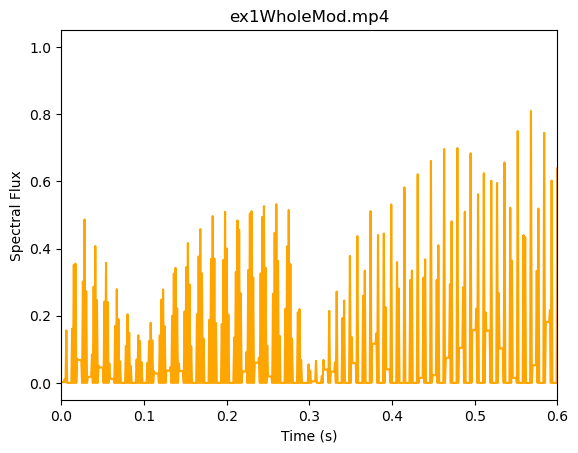

For exercise ex1WholeMod.mp4, Actual: 90, Detected: 47
For exercise ex1WholeModF.mp4, Actual: 90, Detected: 38
For exercise ex2WholeMod.mp4, Actual: 49, Detected: 141
For exercise ex3WholeMod.mp4, Actual: 145, Detected: 232
For exercise ex3WholeModF.mp4, Actual: 145, Detected: 149
For exercise ex4WholeMod.mp4, Actual: 102, Detected: 201
For exercise ex4WholeModF.mp4, Actual: 102, Detected: 149
For exercise ex5WholeMod.mp4, Actual: 133, Detected: 274
For exercise ex5WholeModF.mp4, Actual: 133, Detected: 218
For exercise ex6WholeMod.mp4, Actual: 118, Detected: 111
For exercise ex6WholeModF.mp4, Actual: 118, Detected: 110
For exercise ex7WholeMod.mp4, Actual: 86, Detected: 208
For exercise ex8WholeMod.mp4, Actual: 112, Detected: 108
For exercise ex8WholeModF.mp4, Actual: 112, Detected: 104
For exercise ex9WholeMod.mp4, Actual: 121, Detected: 99
For exercise ex10WholeMod.mp4, Actual: 102, Detected: 109


In [7]:
# ys, ts, sr = get_audio_data("ex6_90bpm_1.wav")
# there are 118 notes articulated within this

# onsets = detect_onsets(spec_flux, ts_fr)
# print(onsets)
# print(len(onsets))


exerciseNoteCounts = [
    ["ex1WholeMod.mp4", 90, .3,  .4],
    ["ex1WholeModF.mp4", 90, .3, .4],
    ["ex2WholeMod.mp4", 49, .15, 0.15],
    ["ex3WholeMod.mp4", 145, .15, 0.15],
    ["ex3WholeModF.mp4", 145, .15, 0.15],
    ["ex4WholeMod.mp4", 102, .15, 0.15],
    ["ex4WholeModF.mp4", 102, .15, 0.15],
    ["ex5WholeMod.mp4", 133, .15, 0.15],
    ["ex5WholeModF.mp4", 133, .15, 0.15],
    ["ex6WholeMod.mp4", 118, .15, 0.15],
    ["ex6WholeModF.mp4", 118, .15, 0.15],
    ["ex7WholeMod.mp4", 86, .15, 0.15],
    ["ex8WholeMod.mp4", 112, .15, 0.15],
    ["ex8WholeModF.mp4", 112, .15, 0.15],
    ["ex9WholeMod.mp4", 121, .15, 0.15],
    ["ex10WholeMod.mp4", 102, .15, 0.15]
]

for exercise, note_count, spec_thresh, min_time_between in exerciseNoteCounts:
    ys, ts, sr = get_audio_data(exercise)

    ts_fr, fr_freq_amps = magnitudeSpectrogram(ys, ts, sr)
    ts_fr, spec_flux = computeSpectralFlux(ts_fr, fr_freq_amps, sr)
    plt.title(exercise)
    plt.xlabel("Time (s)"); plt.ylabel("Spectral Flux")
    plt.plot(ts_fr, spec_flux, c="orange")
    img_path = Path.cwd() / "spec_flux_graphs" / f"{exercise} Spectral Flux.png"
    plt.savefig(img_path)
    if exercise == "ex1WholeMod.mp4":
        plt.xlim((0, .6))
        plt.show()
    else:
        plt.close()
        

    onsets = detect_onsets(spec_flux, ts_fr, threshold=spec_thresh, min_time_between=min_time_between)
    print(f"For exercise {exercise}, Actual: {note_count}, Detected: {len(onsets)}")

In [12]:
def extract_notes_from_recording(mp4_file, min_note_duration=0.1):
    """
    Extract note names in order using librosa's pYIN algorithm from an mp4 recording.
    
    Args:
        mp4_file: Path to the mp4 file containing audio
        min_note_duration: Minimum duration (in seconds) for a note to be considered
        
    Returns:
        List of detected notes with their timing information
    """
    # Get the audio data
    ys, ts, sr = get_audio_data(mp4_file)
    
    # Run the pYIN algorithm
    f0, voiced_flag, voiced_probs = librosa.pyin(
        y=ys, 
        sr=sr, 
        fmin=librosa.note_to_hz('E3'), 
        fmax=librosa.note_to_hz('C6'),
        frame_length=2048,
        hop_length=512
    )
    
    # Get time stamps for each frame
    frame_times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=512)
    
    # Group continuous segments into notes
    notes = []
    current_note = None
    min_frames = int(min_note_duration / (512/sr))  # Convert duration to frames
    
    for i in range(len(f0)):
        if voiced_flag[i] and not np.isnan(f0[i]):
            # Get the note name for this frequency
            note_name = librosa.hz_to_note(f0[i], octave=True)
            
            # Start a new note or continue the current one
            if current_note is None or current_note["name"] != note_name:
                # If we have a previous note, add it to our list if it's long enough
                if current_note and (i - current_note["start_frame"]) >= min_frames:
                    notes.append({
                        "name": current_note["name"],
                        "start_time": frame_times[current_note["start_frame"]],
                        "end_time": frame_times[i-1],
                        "duration": frame_times[i-1] - frame_times[current_note["start_frame"]],
                        "avg_freq": np.mean(current_note["freqs"])
                    })
                
                # Start a new note
                current_note = {
                    "name": note_name,
                    "start_frame": i,
                    "freqs": [f0[i]]
                }
            else:
                # Continue the current note
                current_note["freqs"].append(f0[i])
    
    # Add the final note if it exists
    if current_note and (len(f0) - current_note["start_frame"]) >= min_frames:
        notes.append({
            "name": current_note["name"],
            "start_time": frame_times[current_note["start_frame"]],
            "end_time": frame_times[-1],
            "duration": frame_times[-1] - frame_times[current_note["start_frame"]],
            "avg_freq": np.mean(current_note["freqs"])
        })
    
    print(f"Detected {len(notes)} notes in {mp4_file}:")
    for i, note in enumerate(notes):
        print(f"{i+1}. {note['name']} ({note['start_time']:.2f}s - {note['end_time']:.2f}s, {note['duration']:.2f}s)")
    
    return notes

# Example usage
if __name__ == "__main__":
    notes = extract_notes_from_recording("ex1WholeModF.mp4")

Detected 92 notes in ex1WholeModF.mp4:
1. A♯4 (0.03s - 0.23s, 0.20s)
2. A4 (0.25s - 0.50s, 0.26s)
3. A♯4 (0.51s - 0.73s, 0.21s)
4. F4 (0.78s - 0.93s, 0.15s)
5. C5 (0.97s - 1.19s, 0.22s)
6. B4 (1.21s - 1.45s, 0.25s)
7. C5 (1.46s - 1.67s, 0.21s)
8. F4 (1.72s - 1.93s, 0.21s)
9. D5 (1.94s - 2.15s, 0.21s)
10. C♯5 (2.17s - 2.41s, 0.25s)
11. D5 (2.42s - 2.62s, 0.20s)
12. G4 (2.63s - 2.85s, 0.21s)
13. C5 (2.91s - 3.19s, 0.28s)
14. B4 (3.20s - 3.43s, 0.23s)
15. C5 (3.45s - 3.68s, 0.23s)
16. D♯4 (3.69s - 3.89s, 0.20s)
17. G4 (3.93s - 4.16s, 0.23s)
18. F♯4 (4.17s - 4.42s, 0.25s)
19. G4 (4.43s - 4.67s, 0.25s)
20. C4 (4.70s - 4.85s, 0.15s)
21. G4 (4.98s - 5.19s, 0.21s)
22. F♯4 (5.21s - 5.44s, 0.23s)
23. G4 (5.45s - 5.64s, 0.19s)
24. A♯4 (5.69s - 5.90s, 0.21s)
25. A4 (5.95s - 6.18s, 0.22s)
26. G♯4 (6.19s - 6.43s, 0.25s)
27. A4 (6.44s - 6.62s, 0.18s)
28. C5 (6.68s - 6.86s, 0.18s)
29. A♯4 (6.93s - 8.06s, 1.13s)
30. D♯5 (8.09s - 8.33s, 0.25s)
31. D5 (8.34s - 8.54s, 0.20s)
32. D♯5 (8.55s - 8.77s, 0.21s)